<a href="https://colab.research.google.com/github/gpertea/SPIT/blob/main/SPIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/berilerdogdu/SPIT/main/spitting_llama.png" height="200" align="left" style="height:240px">

#DTU Analysis with SPIT

Perform differential transcript usage (DTU) analysis through the SPIT pipeline in this interactive notebook environment. Check out the GitHub page if you prefer your terminal: https://github.com/berilerdogdu/SPIT

P.S. This animal is a llama. Llamas [SPIT](https://www.youtube.com/watch?v=dcturgyE_gg).

In [1]:
#@title Clone the project (you must do this if you want anything to work, even for the easy run).
!git clone https://github.com/berilerdogdu/SPIT.git

Cloning into 'SPIT'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 313 (delta 116), reused 176 (delta 91), pack-reused 77
Receiving objects: 100% (313/313), 7.59 MiB | 23.07 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [ ]:
#@title Mount Google Drive
#@markdown If you would like to use/write files in your Google Drive, mount it to this notebook.
from google.colab import drive
drive.mount('/content/drive')
from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

#**Easy run**
If you are a returning user or completed the tutorial already, you can proceed by specifying your input files and executing the entire SPIT pipeline with default settings in a single cell. For examples of each of these input files, please download the sample data in the tutorial section.

In [ ]:
#@markdown ##Here is a list of all input files you will need to run SPIT:

tx_counts = '/content/drive/MyDrive/DTU_data/tx_counts.txt' #@param {type:"string"}
#@markdown  - **Transcript level counts file**: You need to create a tab-separated file containing the transcript counts for all samples. The rows should correspond to the transcripts, and the columns should represent the samples. The file should include a header with the sample IDs, and a first column with the unique transcript IDs, which must be named "tx_id". We recommend using the "tximport"[1] package in R with the "scaledTPM" option, but raw counts can also be used.

tx2gene = '/content/SPIT/example_analysis/refseq_tx2gene' #@param {type:"string"}
#@markdown  - **Transcript to gene mapping file**: You need a tab-separated file that links each transcript ID in the count file to its corresponding gene ID. The first column should contain the transcript IDs and be labeled as "tx_id", while the second column should contain the gene IDs and be labeled as "gene_id".

pheno = '/content/SPIT/example_analysis/pheno.txt' #@param {type:"string"}
#@markdown  - **Pheno data file**: You need a tab-separated file containing all relevant phenotype data. The file should include two columns: "id," which corresponds to the sample IDs, and "condition," which labels the control samples as "0" and the disease group as "1". If you are not conducting a disease analysis, you can label your groups arbitrarily as "0/1". It's essential to ensure that all sample IDs in the phenotype data file match those included in the transcript level counts file. You may provide any additional covariates (age, race, etc.) with distinct column names for confounding control. For any categorical (not numerical) covariates, you should name the corresponding column with the suffix "_cat", as this will signal the program to factorize that covariate. For example, if you have "sex" as one of your covariates and you would like to run the confounding control module, name the column corresponding to "sex" in your pheno data file as "sex_cat".

result_dir = '/content/drive/MyDrive/DTU_data/results' #@param {type:"string"}
#@markdown - Preferred directory for your result files (potentially in your Google Drive).

import os
if not os.path.exists(result_dir):
  os.makedirs(result_dir)
result_dir = result_dir.rstrip("/")+"/"
#@markdown ---
#@markdown ### Main advanced settings
#@markdown Default values are provided. For detailed explanations, please see the tutorial below.
K = 0.6 #@param {type:"number"}
#@markdown - Hyperparameter for p-value thresholding
b = 0.09 #@param {type:"number"}
#@markdown - Choice of bandwidth for kernel density estimation
n_small = 12 #@param {type:"integer"}
#@markdown - Smallest sample size for the subgroups


In [ ]:
#@title Run SPIT pipeline
#@markdown You may also modify the parameters by adjusting the command line arguments within the cell.
!echo "> Pre-filtering transcript counts and generating isoform fractions:"
!python ./SPIT/filter_and_transform_tx_counts.py -i $tx_counts -m $tx2gene -l $pheno -n $n_small -T ./filtered_tx_counts.txt -F ./filtered_ifs.txt -G ./filtered_gene_counts.txt --write
!echo "> Running SPIT Test with 1000 iterations:"
!python ./SPIT/spit_test.py -i ./filtered_ifs.txt -g ./filtered_gene_counts.txt -l $pheno -n 1000 --n_small $n_small -I ./dominance_selected_ifs.txt -G ./dominance_selected_gene_counts.txt -P ./spit_test_min_p_values.txt
#Default values of hyperparameters k and bandwidth:
p_threshold = !python ./SPIT/get_p_cutoff.py -k $K -p ./spit_test_min_p_values.txt
p_threshold = p_threshold[0]
!echo "> Comparing the case and control samples with default parameters k=0.6 and bandwidth=0.09:"
!python ./SPIT/dtu_detection.py -i ./dominance_selected_ifs.txt -g ./dominance_selected_gene_counts.txt -m $tx2gene -l $pheno --p_cutoff $p_threshold -b $b -n $n_small -M ./spit_cluster_matrix.txt -O ./spit_out.txt
!echo "> Applying confounding analysis based on the provided pheno-data. The resulting permutation importance plots for all candidate DTU transcripts will be outputted into 'importance_score_plots.pdf' in the current directory."
!python ./SPIT/confounding_analysis.py -i ./dominance_selected_ifs.txt -l $pheno --cluster_matrix ./spit_cluster_matrix.txt -n $n_small -o ./spit_out.txt -M ./controlled_spit_cluster_matrix.txt -O ./controlled_spit_out.txt -P ./importance_score_plots.pdf

#**Tutorial and example analysis**

In this module, we illustrate the application of pre-filtering, SPIT-Test, DTU detection, and confounding control steps of the SPIT pipeline using an example dataset. Our demonstration highlights the process of transforming input transcript counts to detect DTU events, controlling for confounding variables, and exploring potential subclusters in your disease group. Please note that if you wish to employ the optional cross-validation based parameter-fitting process on your data, you will need to clone the GitHub project and run it locally, as there are runtime limitations with Google Colab.

To perform these steps on your own dataset, you can upload the data to Google Drive and mount it, or directly upload to session storage. We recommend using Google Drive as files stored in session storage are lost after each runtime. Once your data is uploaded, you can simply replace the file names in the notebook cells with your own and rerun the pipeline. Don't forget to download all output files once the pipeline is completed.

In [ ]:
#@markdown Download the sample data:
!gdown -O ./SPIT/example_analysis/tx_counts.txt 1hGoCMCxwd1_oXN_sFe3OIHTa2GABwV3H
!gdown -O ./SPIT/example_analysis/ifs_sim.txt 1VXB41fOL4duefyy9S6J-WLPWklGiXkpc
!gdown -O ./SPIT/example_analysis/gene_counts_sim.txt 1DRccXn9dMnSa29hDesPwqlwyjrFU_jQI

Define your input files as variables:

In [ ]:
tx_counts = "./SPIT/example_analysis/tx_counts.txt"
tx2gene = "./SPIT/example_analysis/refseq_tx2gene"
pheno = "./SPIT/example_analysis/pheno.txt"

<img src="https://raw.githubusercontent.com/berilerdogdu/SPIT/main/filtering_llama.png?token=GHSAT0AAAAAACBYAURBVDZS7BDU3EIMYNH6ZCE3BAQ" height="200" align="right" style="height:240px">

###Pre-filtering

The default behavior of SPIT involves the conservative pre-filtering steps listed below which build upon the *DRIMSeq*[2] filtering criteria. We define ***n*** as the smallest sample size presumed for the subgroups within populations which is a user-set parameter of SPIT and defaults to **12**.

1.     Each transcript must have a Counts per million (CPM) value of at least 10 in at least ***n*** samples.
2.     Each transcript must have a positive read count in at least a ***r*** fraction of the samples in both the case and control groups, respectively. ***r*** is a user-set parameter and defaults to **0.20**.
3.     Each gene must have a read count of at least ***c*** in at least ***s*** samples, where ***c*** and ***s*** are user-set parameters and default to **10**.
4.     Each transcript must have an IF value larger than ***f*** in at least ***n*** samples, where ***f*** is a user-set parameter and defaults to **0.1**.
5.     After the filtering steps above, there must remain at least 2 transcripts for each gene.

The pre-filtering script is called as below:

In [ ]:
!python ./SPIT/filter_and_transform_tx_counts.py -h

Define your output files as variables:

In [ ]:
filtered_tx_counts = "./filtered_tx_counts.txt"
filtered_ifs = "./filtered_ifs.txt"
filtered_gene_counts = "./filtered_gene_counts.txt"

In [ ]:
!python ./SPIT/filter_and_transform_tx_counts.py -i $tx_counts -m $tx2gene -l $pheno -T $filtered_tx_counts -F $filtered_ifs -G $filtered_gene_counts --write

If you would like to skip pre-filtering, you may convert your transcript counts into IFs as follows. Please note that transcripts without any non-zero counts will still be filtered out.

In [ ]:
!python ./SPIT/transform_tx_counts_to_ifs.py -h

###SPIT-Test

SPIT-Test is an iterative process which randomly splits the control group in half, and identifies the most significant difference in isoform fractions between the two halves. Later on, the candidate DTU events between the case and control groups are compared, in terms of their significance, to the observed differences between random halves of the control group.

The SPIT-Test module is called as below:

In [ ]:
!python ./SPIT/spit_test.py -h

The dominance threshold ensures that the control group has a consistently dominant isoform for each gene examined. This criterion is met for a gene when the same isoform of the gene has the largest IF in at least a fraction (***d***) of the control samples, where ***d*** is a user-set parameter and defaults to 0.75. If you prefer not to employ this filter, set ***d*** to 0. The number of iterations for the sample analysis is set to 10 below to save time, but we recommend increasing it to 1000 for your analysis.

Define your output files as variables:

In [ ]:
dominance_selected_ifs = "./dominance_selected_ifs.txt"
dominance_selected_gene_counts = "./dominance_selected_gene_counts.txt"
sampled_p_values = "./spit_min_p_values.txt"

In [ ]:
!python ./SPIT/spit_test.py -i $filtered_ifs -g $filtered_gene_counts -l $pheno -n 10 -I $dominance_selected_ifs -G $dominance_selected_gene_counts -P $sampled_p_values

###DTU Detection

We use the null minimal p-value distribution to determine a threshold for detecting DTU events. Specifically, any transcript with a p-value lower than this threshold is considered a significant DTU transcript. The threshold is determined based on the user-defined parameter "***K***" and is obtained as the "***K x N***"-th smallest p-value among the ***N*** sampled by SPIT-Test.

The parameter (***b***) controls the bandwidth for the kernel density estimator that is used to detect group partitions.

We have empirically estimated the optimal values for these parameters as ***K*** = 0.6 and ***b*** = 0.09 using GTEx[3] data. For more details, please see the publication. You can input these values as shown below, or you can use the optional cross-validation-based parameter-fitting process on your dataset. If you wish to use the parameter-fitting option, you will need to clone the GitHub project and run it locally.

In [ ]:
K = 0.6
b = 0.09
p_threshold = !python ./SPIT/get_p_cutoff.py -k $K -p $sampled_p_values
p_threshold = p_threshold[0]

In [ ]:
p_threshold

The DTU detection module is called as below:

In [ ]:
!python ./SPIT/dtu_detection.py -h

Note that, here, we use simulated input IFs and gene counts that have artificial DTU events introduced into them for the sake of demonstration. We also use the p-threshold we get after 1000 iterations of SPIT test rather than 10.

**Skip this step if you are running your own analysis!**

In [ ]:
dominance_selected_ifs = "./SPIT/example_analysis/ifs_sim.txt"
dominance_selected_gene_counts = "./SPIT/example_analysis/gene_counts_sim.txt"

Define your output files as variables:

In [ ]:
spit_cluster_matrix = "./spit_cluster_matrix.txt"
spit_out = "./spit_out.txt"

In [ ]:
!python ./SPIT/dtu_detection.py  -i $dominance_selected_ifs -g $dominance_selected_gene_counts -m $tx2gene -l $pheno --p_cutoff $p_threshold -b $b -M $spit_cluster_matrix  -O $spit_out

Check out the candidate DTU genes SPIT detected and flagged:

In [ ]:
!cat $spit_out

##Controlling for confounding variables

For the transcripts that SPIT reports as significant DTU events, the corresponding binary vector in the SPIT clustering matrix represents a partitioning of all samples, case and control, into two groups with high and low IF values. In the presence of a confounding effect, this partition of the high and low IF values can also be achieved via the confounding variable if included in the experimental design.

In order to determine any confounding factors, we fit a random forest regressor on each detected DTU transcript. The same number of samples as in the input matrix is bootstrapped for the construction of each tree with maximum tree depth 1, and we minimize the L2 loss on the mean IF in terminal nodes. Notice that with tree-depth 1, our goal is not to precisely predict the IF value for each sample as much as it is to assess which covariates might be contributing into observable variance in IF values.

To estimate the importance of each covariate as well as the SPIT output vector in the partitioning of high and low IF samples, we conduct a permutation importance test on each random forest. We require that the drop in accuracy caused by permutation of the SPIT binary vector is at least higher than the third quartile (Q3) of any other covariate included for a candidate DTU transcript to remain in the list of significant DTU events.

Below we run this module on our results and represent the transcripts that pass the above criteria with color blue, while those that fail because of potential confounding are colored red. For further details, please refer to the publication.

In [ ]:
!python ./SPIT/confounding_analysis.py -h

Define your output files as variables:

In [ ]:
controlled_spit_cluster_matrix = "./controlled_spit_cluster_matrix.txt"
controlled_spit_out = "./controlled_spit_out.txt"
importance_score_plots = "./importance_score_plots.pdf"

In [ ]:
!python ./SPIT/confounding_analysis.py -i  $dominance_selected_ifs -l $pheno --cluster_matrix $spit_cluster_matrix -o $spit_out -M $controlled_spit_cluster_matrix -O $controlled_spit_out -P $importance_score_plots

These two examples are from the resulting plots (you can find all of them in your *importance_score_plots* PDF file) of confounding control analysis we ran on the sample data. The left panel shows a candidate transcript that passed the filters and is included in the final set of DTU transcripts. The right panel, however, shows a transcript that was initially a candidate for a DTU event, but got eliminated by the confounding control step for potential confounding effects by the"age" covariate.

<img src="https://github.com/berilerdogdu/SPIT/raw/main/perm_example_plots.png" height="240" align="center" style="height:240px">

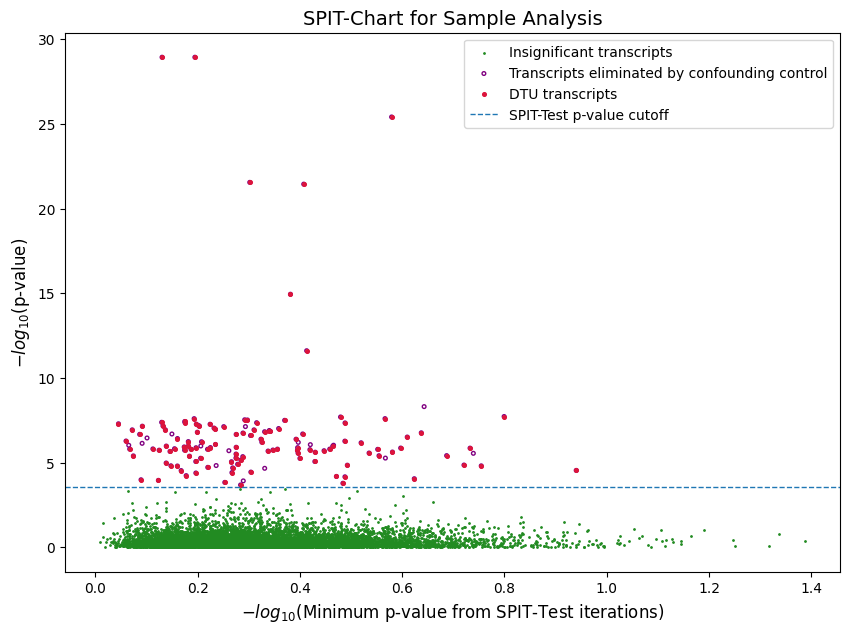

In [ ]:
#@title Plot a SPIT-Chart for your analysis
#@markdown A SPIT-Chart allows you to visualize the *p*-values of your final DTU transcripts in comparison to the *p*-values gathered from all transcripts in your dataset. For each transcript that passed the initial pre-filtering steps, the median p-value that has been observed through 1000 iterations of the SPIT-Test is plotted on the x-axis, and the *p*-value observed in the actual comparison of the case and control samples is plotted on the y-axis, both on -log10 scale. Here, we represent the final DTU transcripts in red, and the candidate transcripts that were eliminated by the confounding control step in unfilled purple circles. The remaining transcripts are shown in green. You can customize the SPIT-Chart according to your preferences using the generation code below.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pre_conf_cluster_m = pd.read_csv(spit_cluster_matrix, sep = '\t', index_col = 0)
pre_conf_dtu_txs = pre_conf_cluster_m[(pre_conf_cluster_m == 1).any(axis = 1)].index.to_list()
sig_tx_ids = pd.read_csv(controlled_spit_cluster_matrix, sep = '\t', index_col = 0).index.to_list()
dtu_comp_p_values = pd.read_csv('./all_p_values.txt', sep = '\t', index_col = 0, header = 0, names = ['p_value'])
perm_p_values = pd.read_csv('./perm_p_medians.txt', sep = '\t', index_col = 0, header = 0, names = ['perm_min_p_value'])
joint_p_df = perm_p_values.join(dtu_comp_p_values)
joint_p_dtu_pre_conf_df = joint_p_df.loc[pre_conf_dtu_txs]
joint_p_dtu_df = joint_p_df.loc[sig_tx_ids]
non_dtu_txs = list(set(joint_p_df.index.to_list()).difference(set(pre_conf_dtu_txs)))
joint_p_non_dtu_df = joint_p_df.loc[non_dtu_txs]
plt.rcParams['figure.figsize'] = [10, 7]
plt.scatter(-np.log10(joint_p_non_dtu_df['perm_min_p_value']), -np.log10(joint_p_non_dtu_df['p_value']), s = 1, color = 'forestgreen', label='Insignificant transcripts')
plt.scatter(-np.log10(joint_p_dtu_pre_conf_df['perm_min_p_value'].to_list()), -np.log10(joint_p_dtu_pre_conf_df['p_value'].to_list()), s = 7, marker = 'o', facecolors='none', color = 'purple', label='Transcripts eliminated by confounding control')
plt.scatter(-np.log10(joint_p_dtu_df['perm_min_p_value'].to_list()), -np.log10(joint_p_dtu_df['p_value'].to_list()), s = 7, marker = 'o', color = 'crimson', label='DTU transcripts')
plt.axhline(y=-np.log10(float(p_threshold)), linestyle='dashed', linewidth=1, label='SPIT-Test p-value cutoff')
plt.ylabel('$-log_{10}$(p-value)', fontsize = 12)
plt.xlabel('$-log_{10}$(Minimum p-value from SPIT-Test iterations)', fontsize = 12)
plt.title("SPIT-Chart for Sample Analysis", fontsize = 14)
plt.legend(fontsize=10)
plt.show()

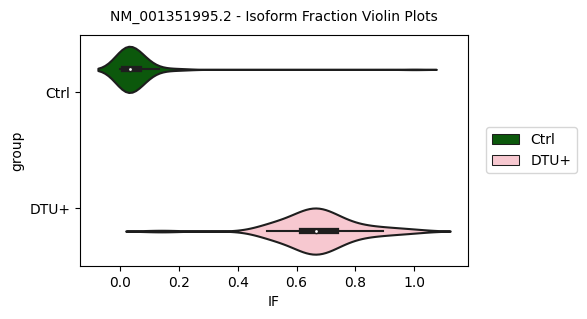

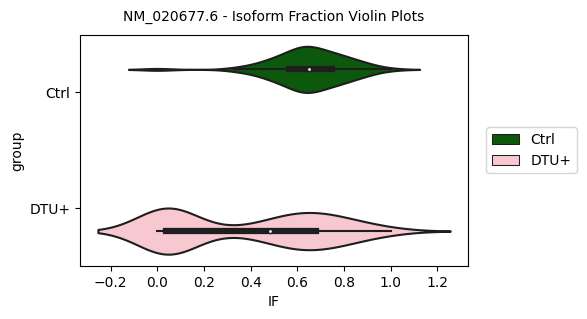

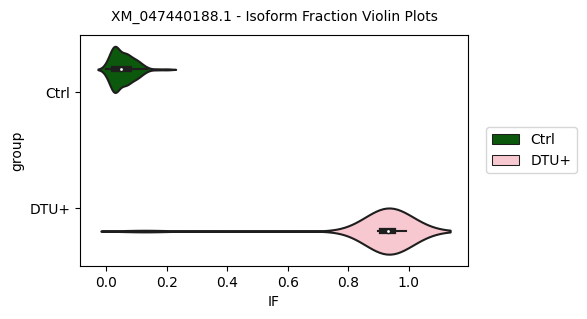

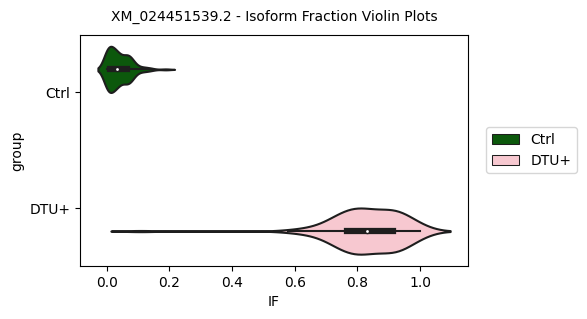

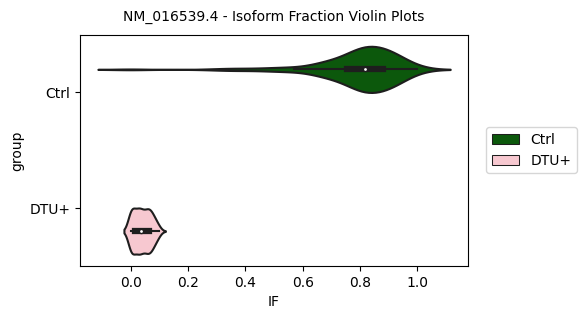

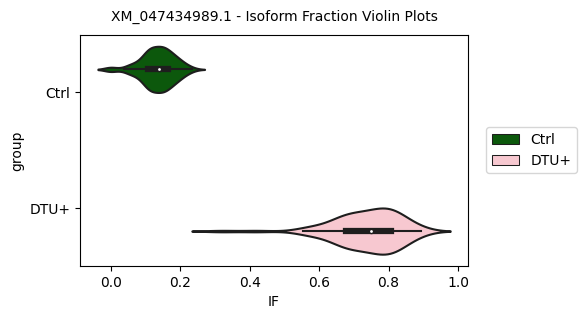

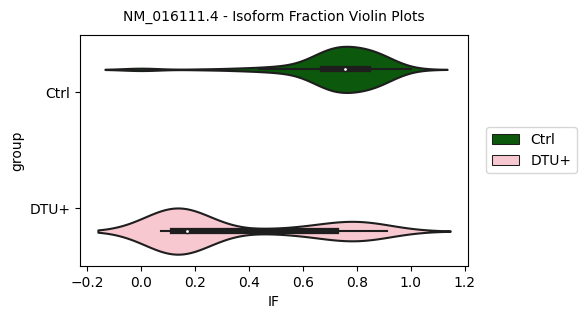

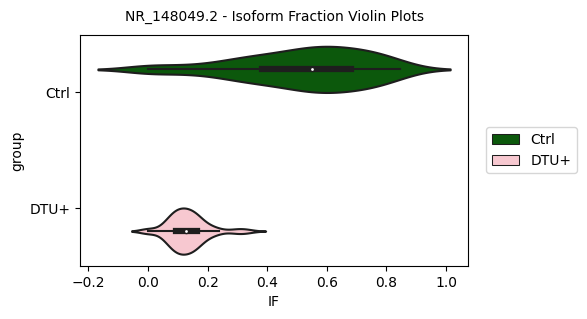

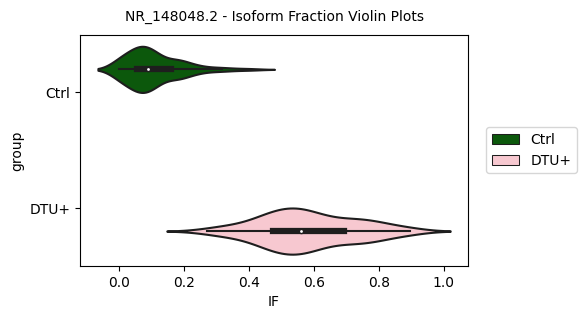

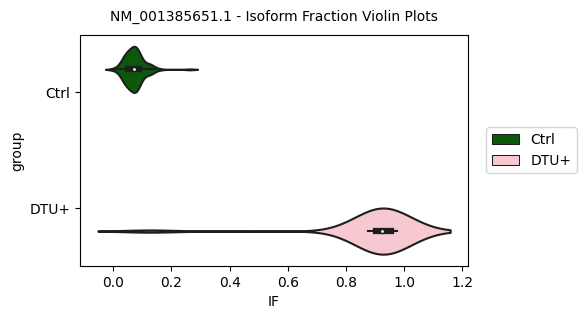

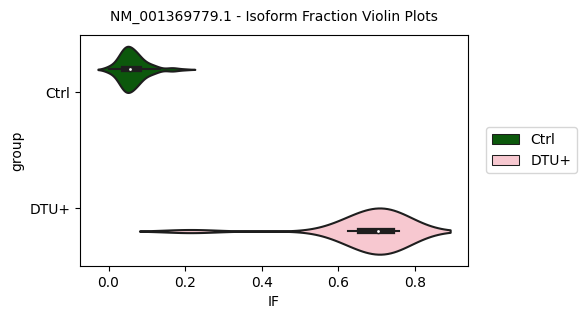

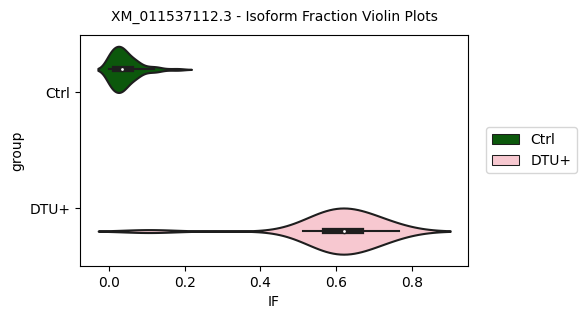

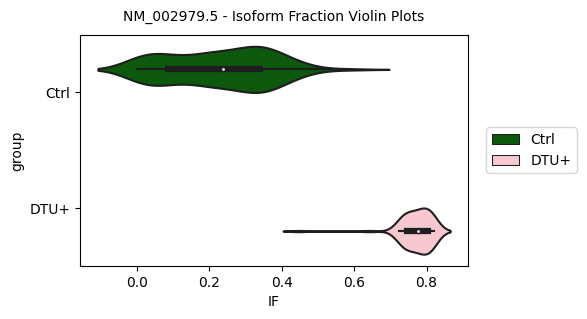

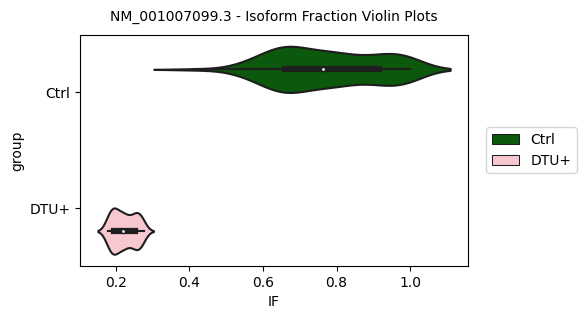

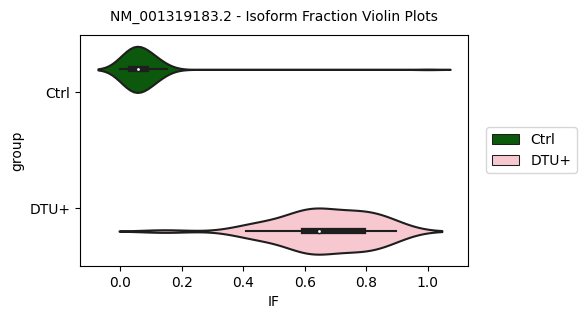

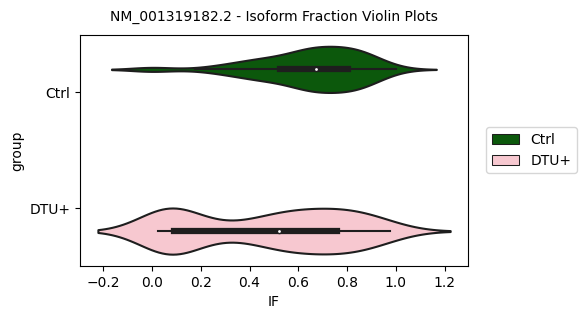

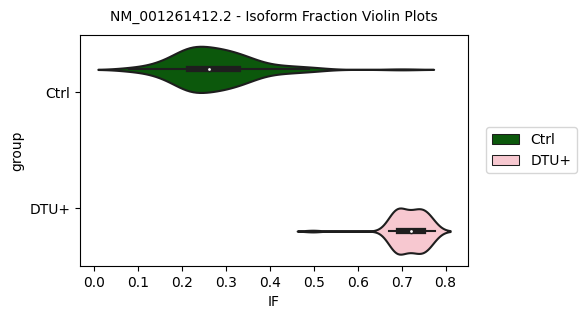

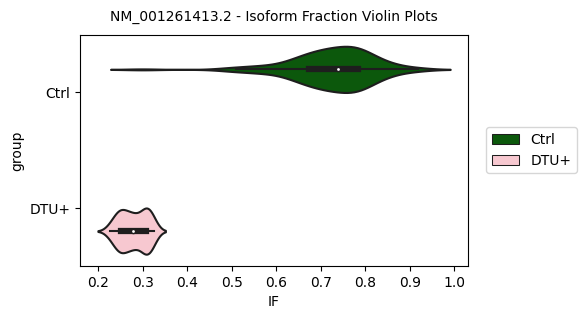

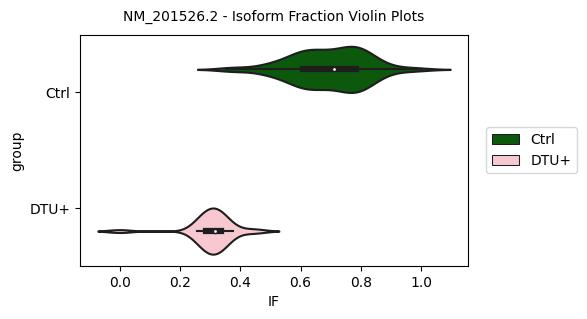

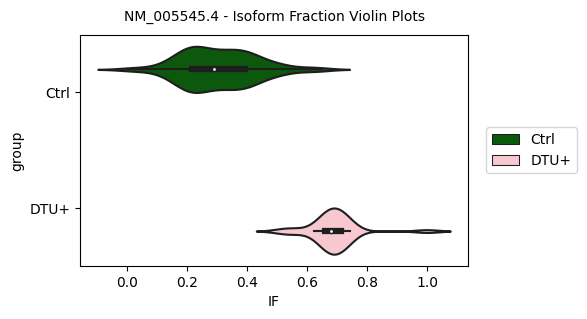

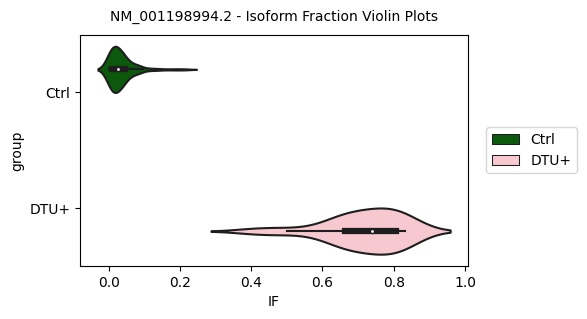

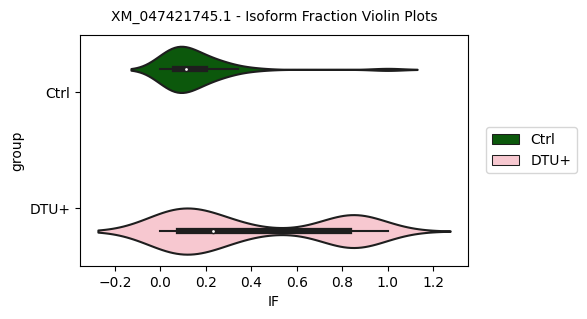

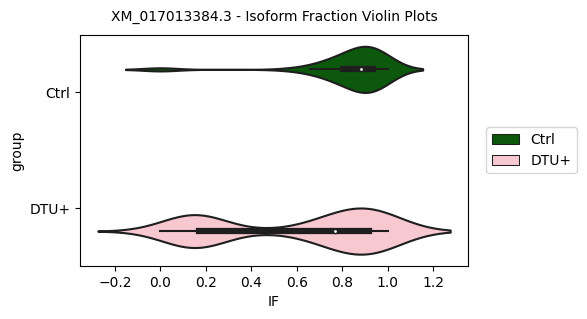

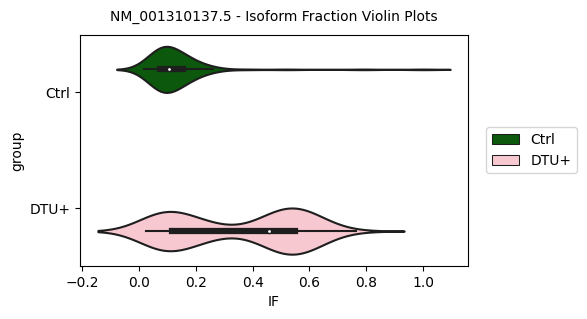

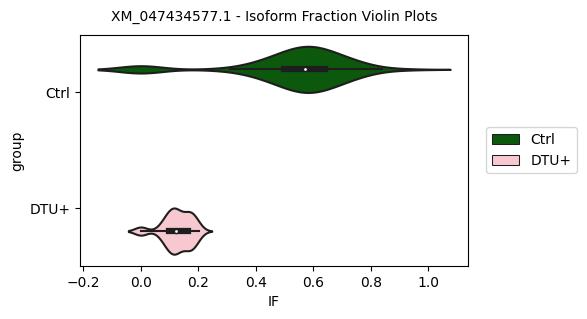

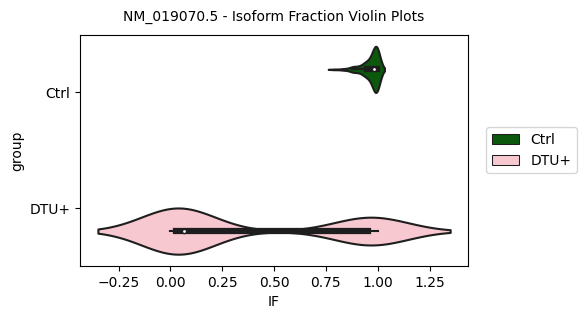

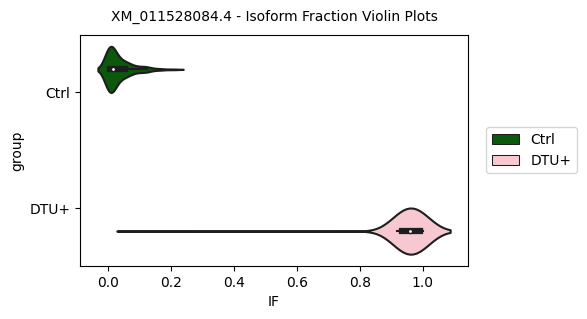

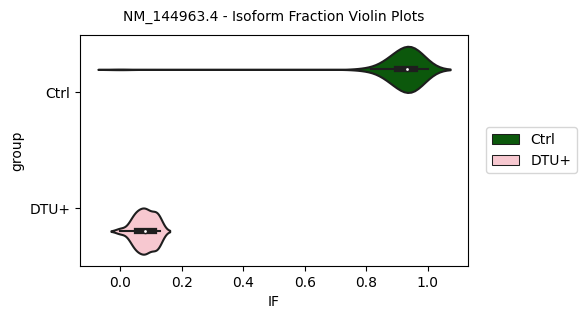

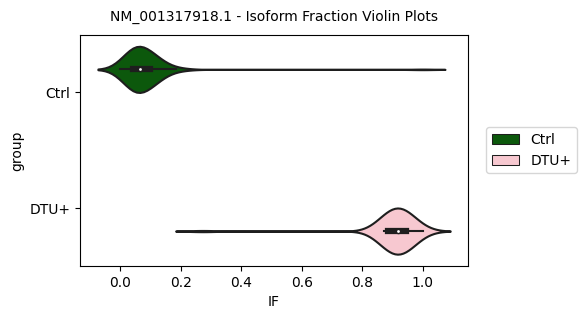

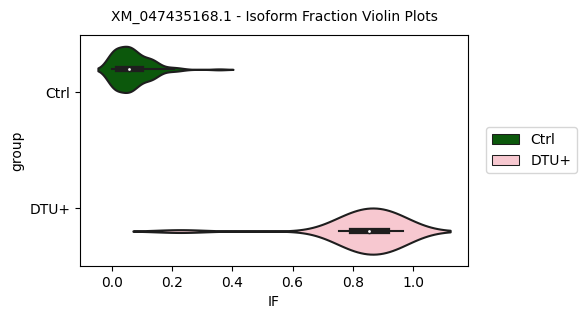

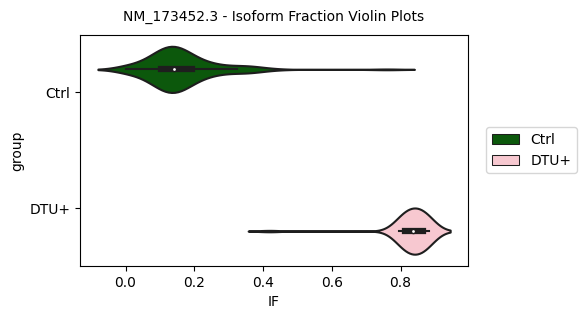

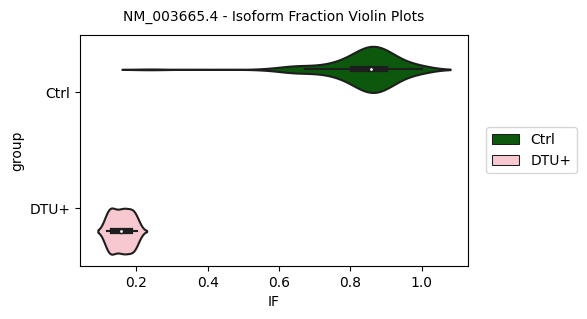

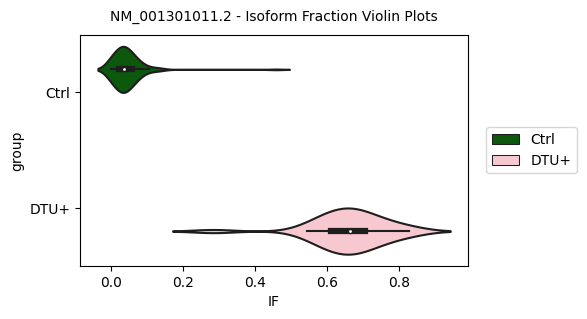

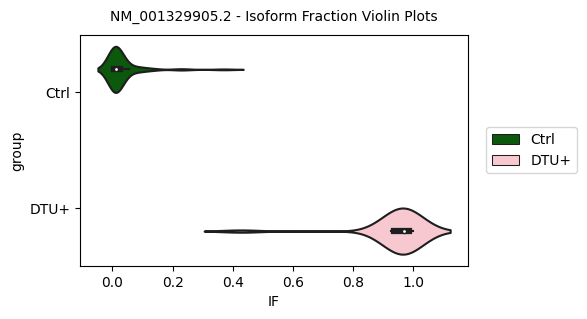

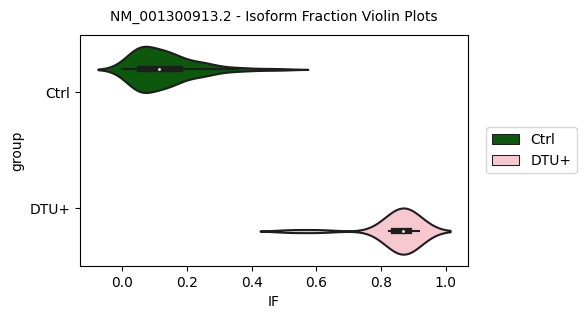

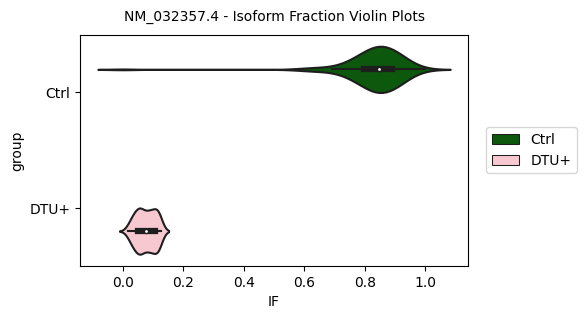

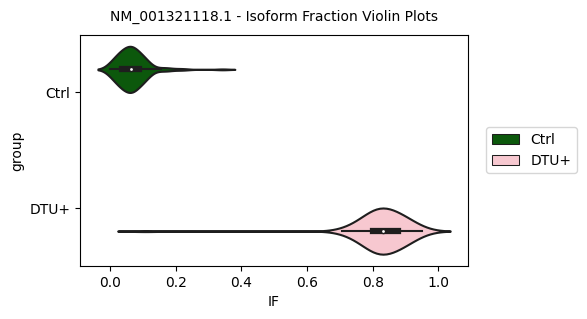

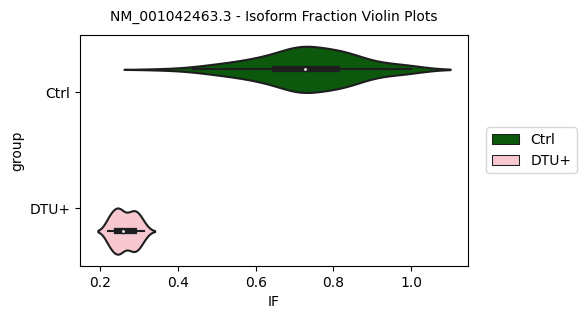

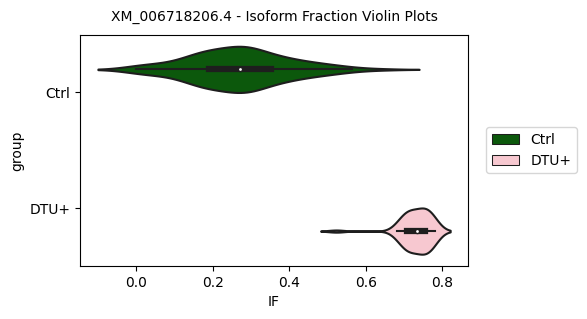

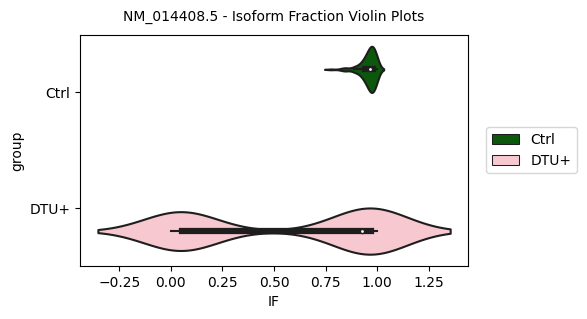

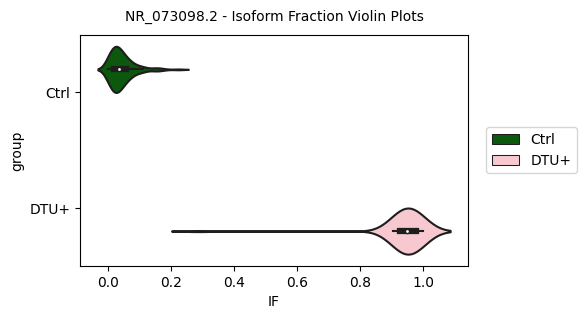

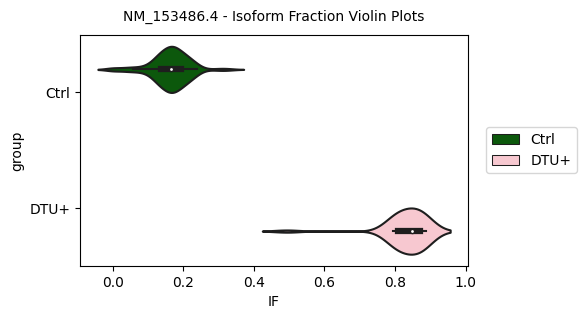

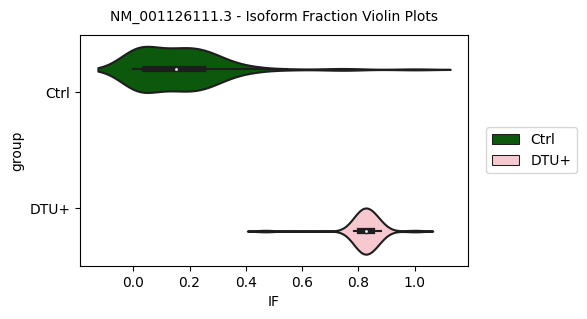

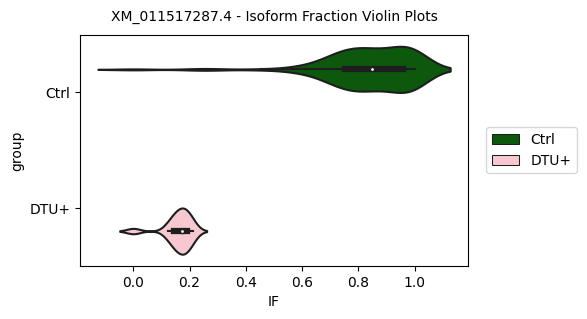

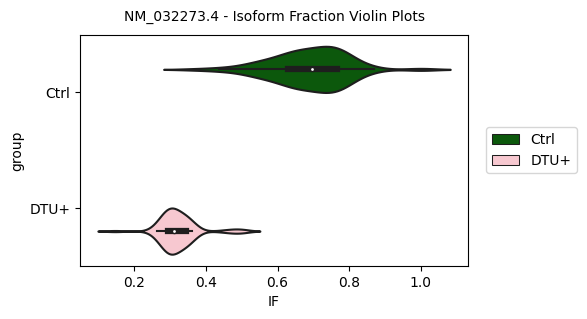

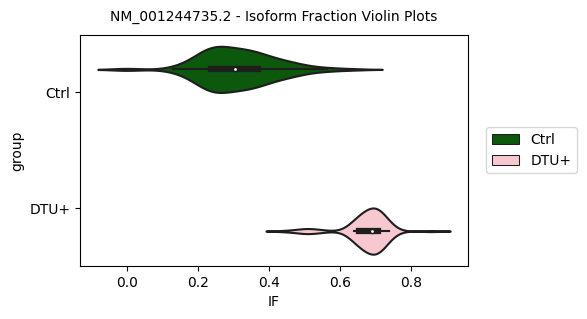

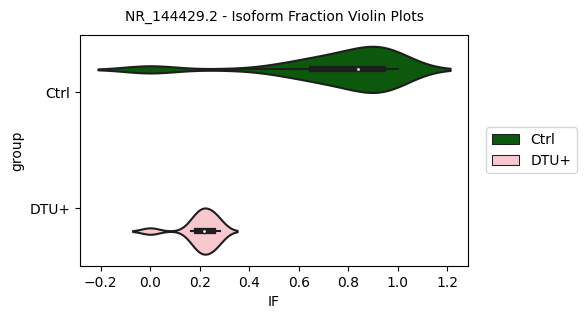

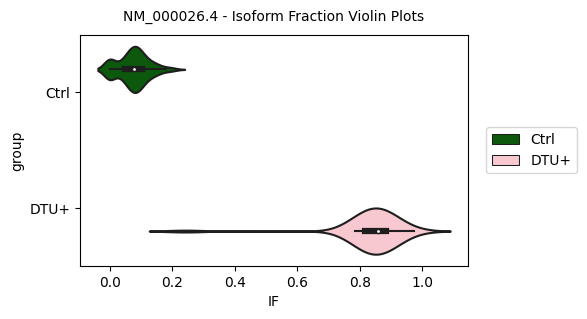

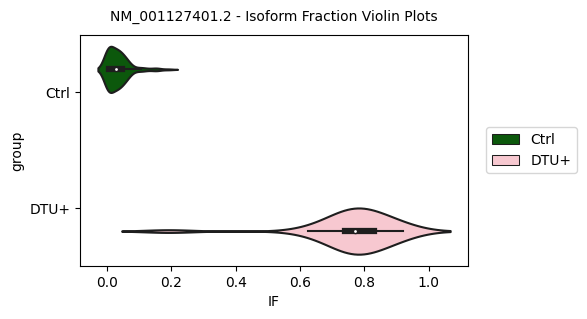

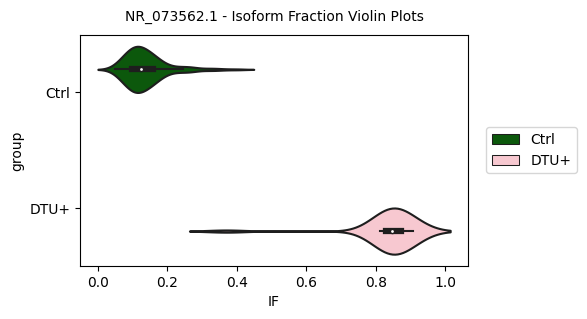

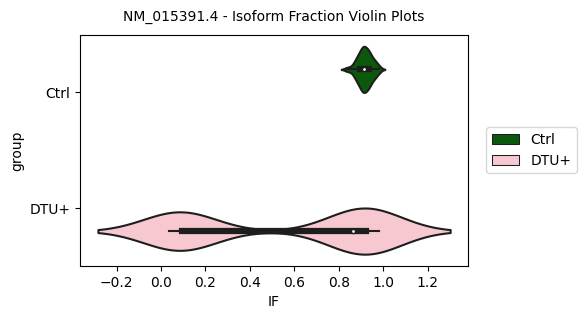

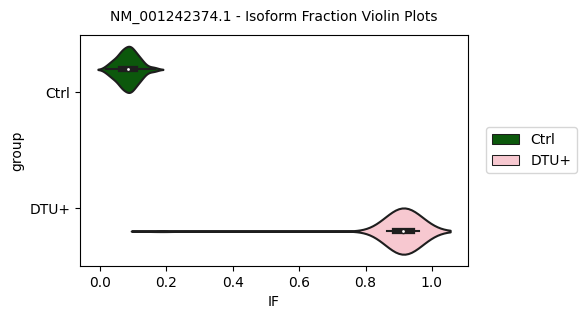

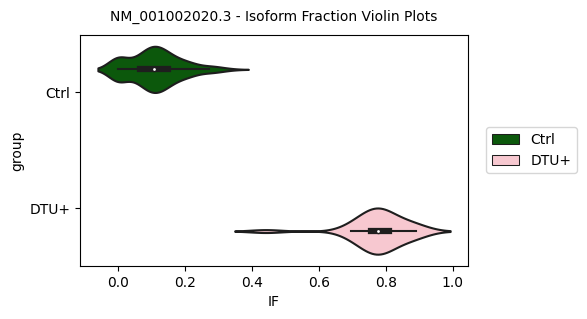

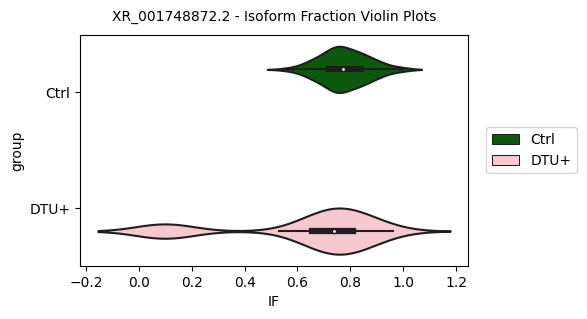

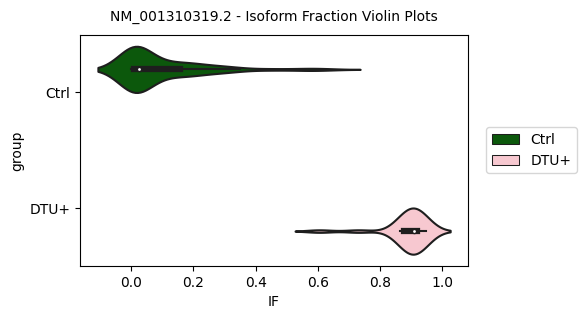

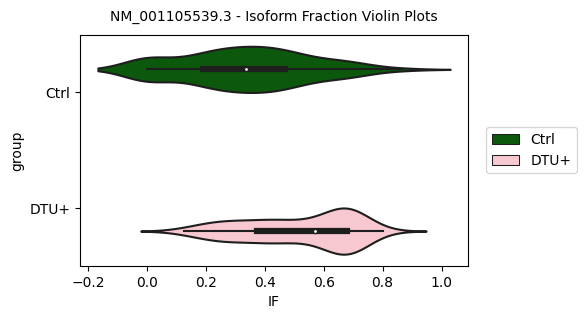

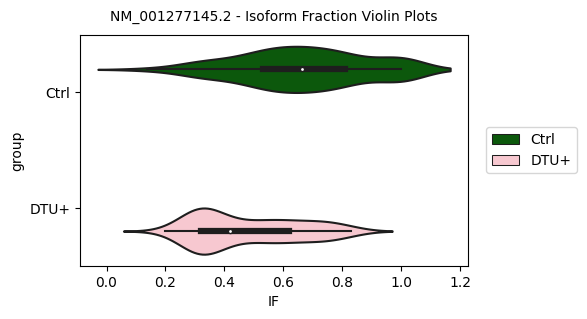

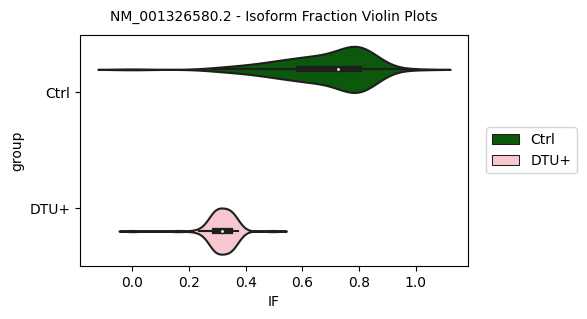

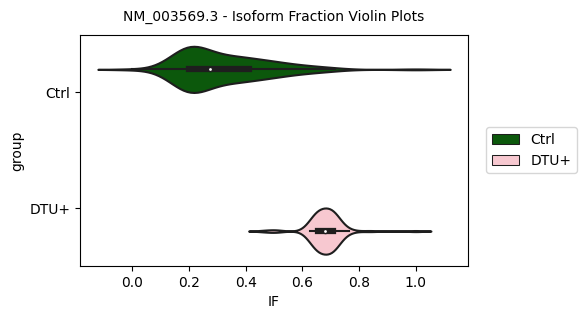

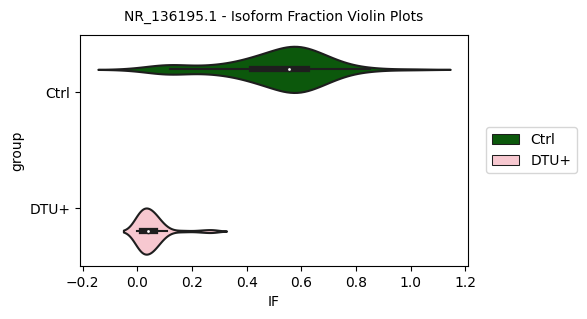

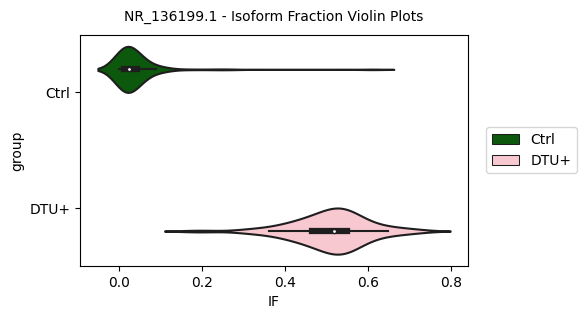

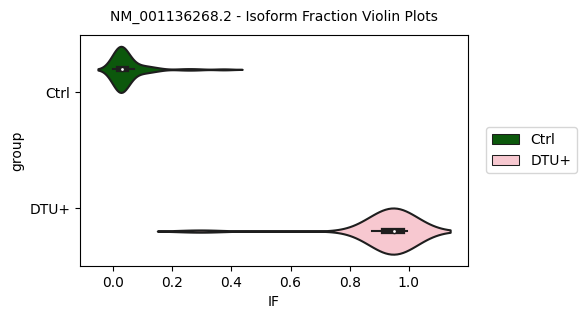

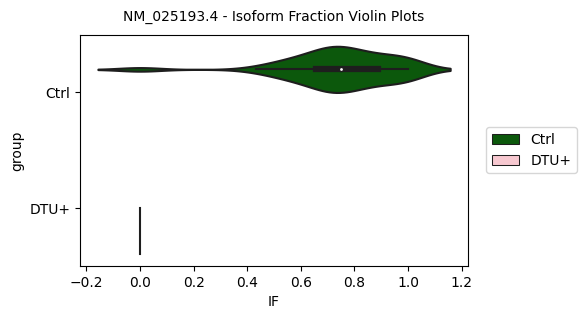

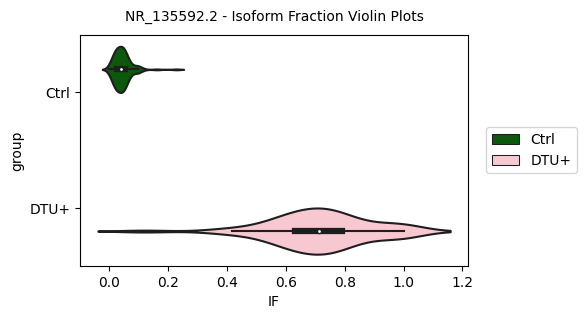

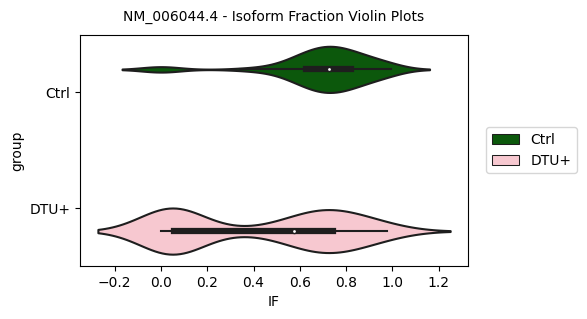

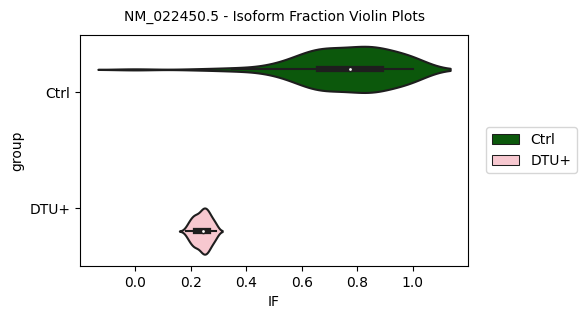

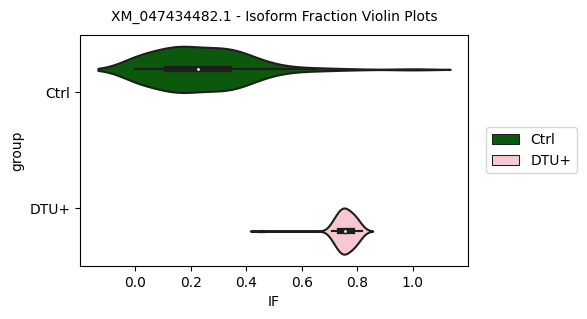

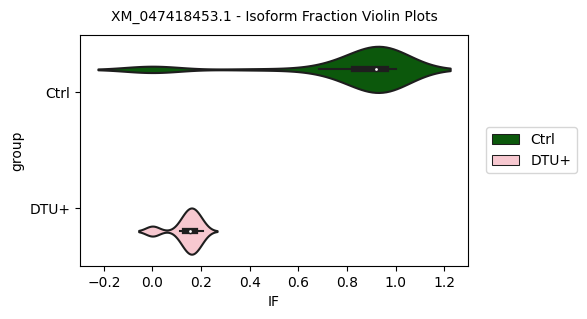

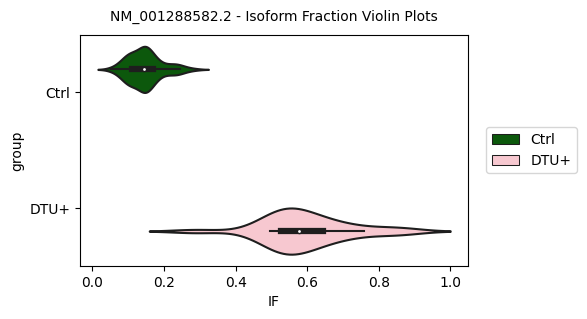

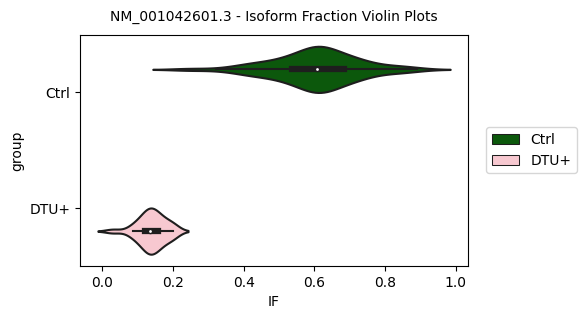

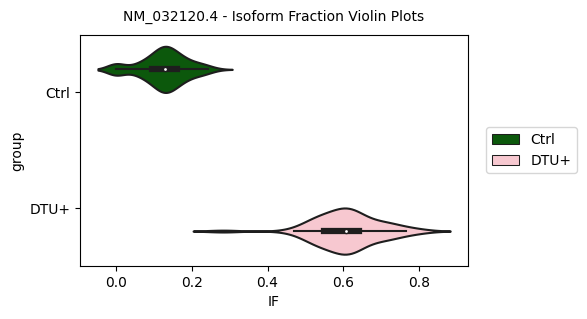

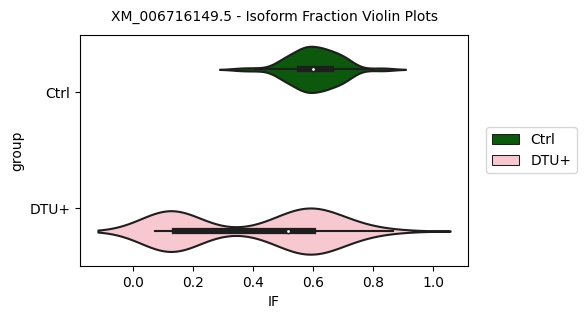

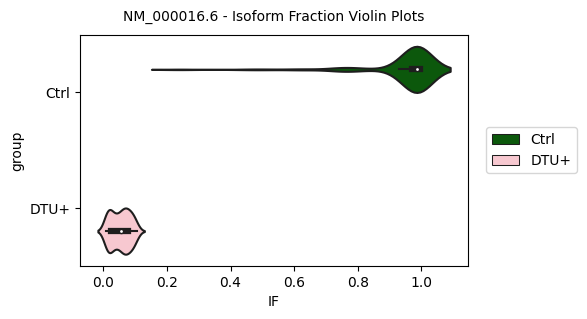

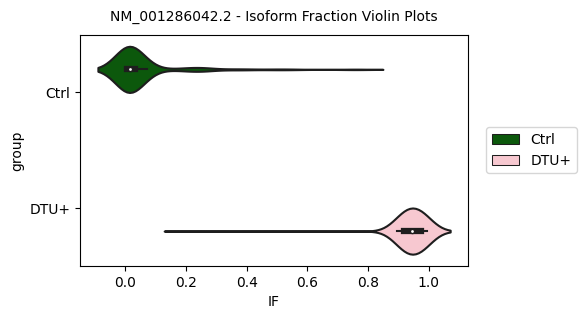

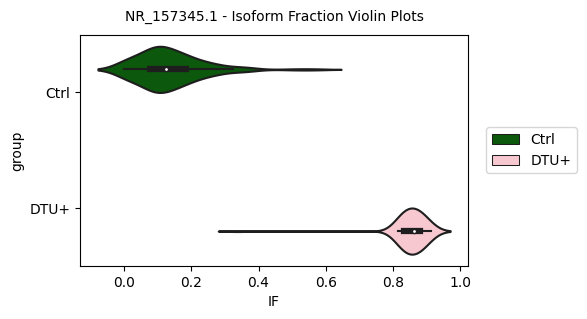

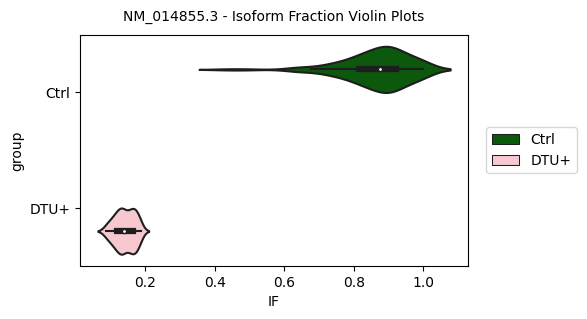

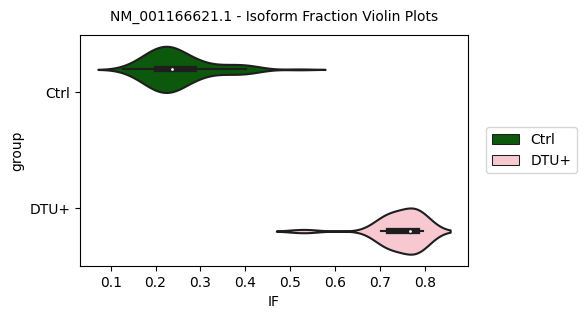

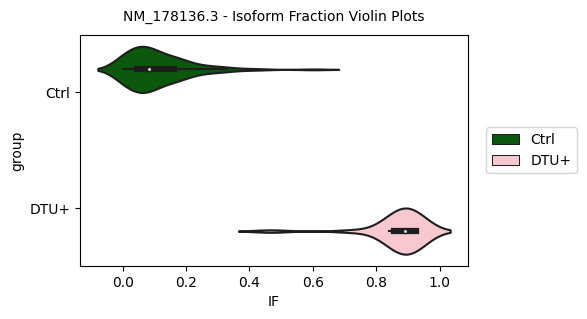

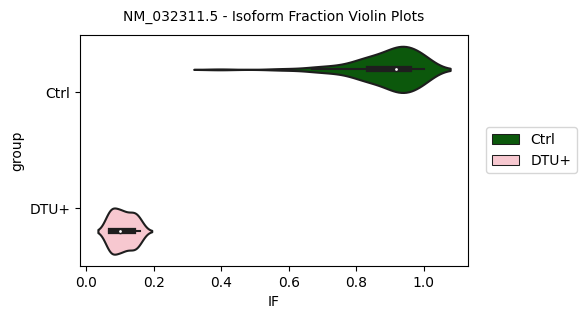

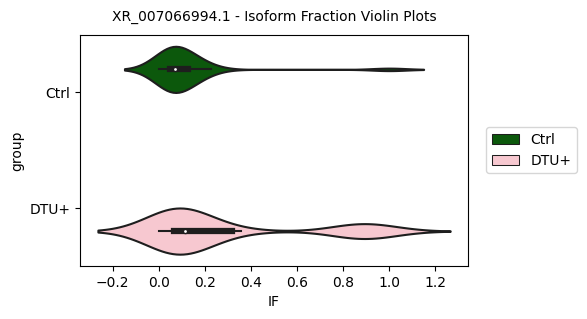

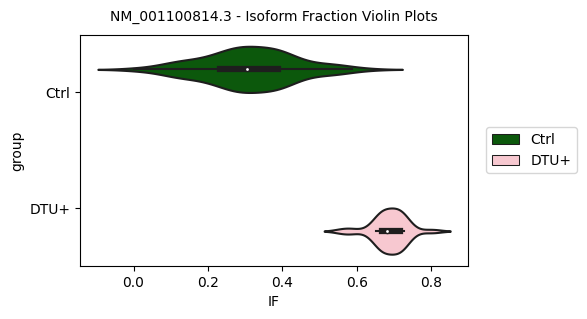

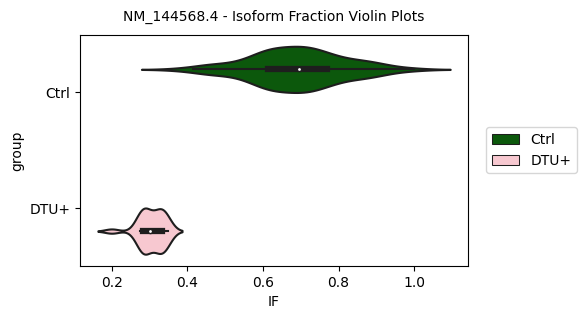

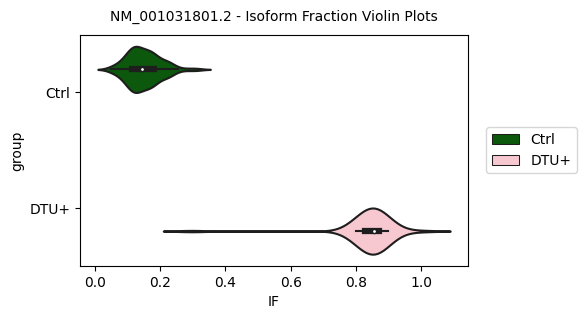

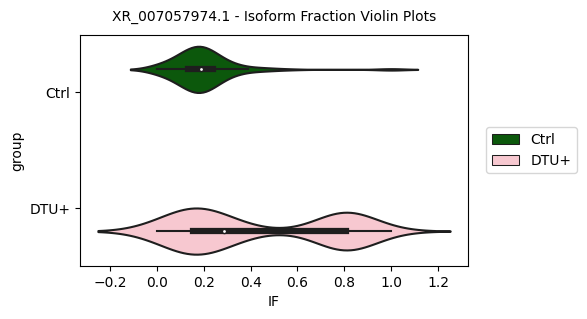

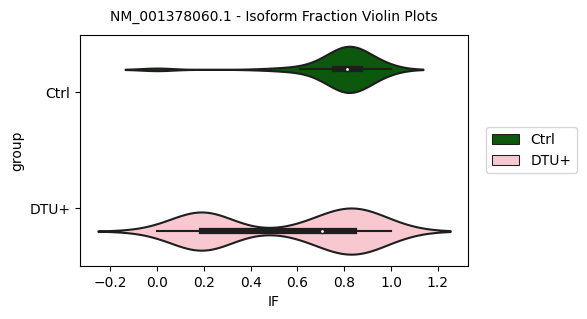

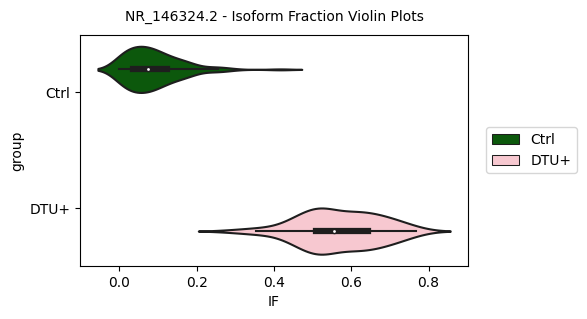

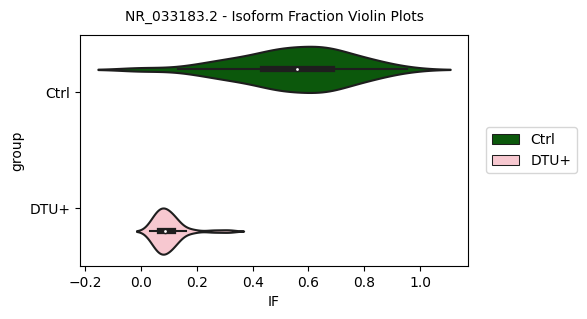

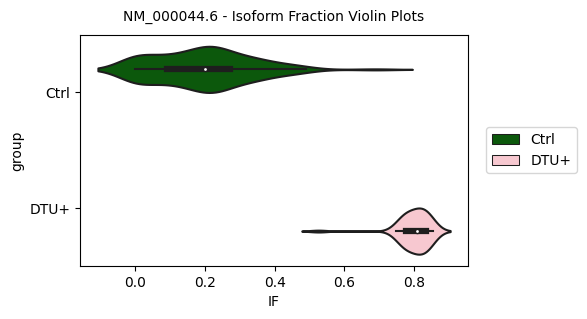

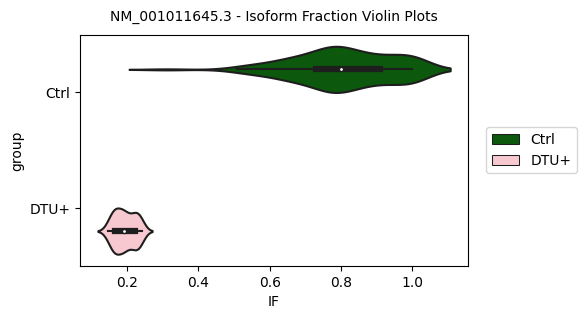

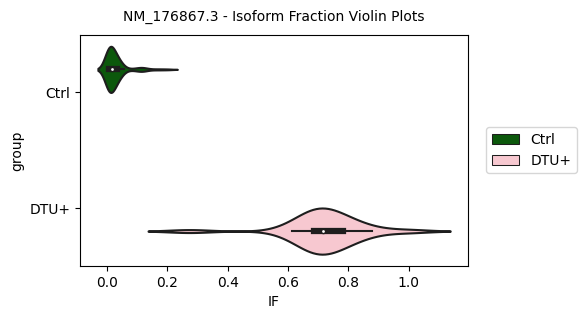

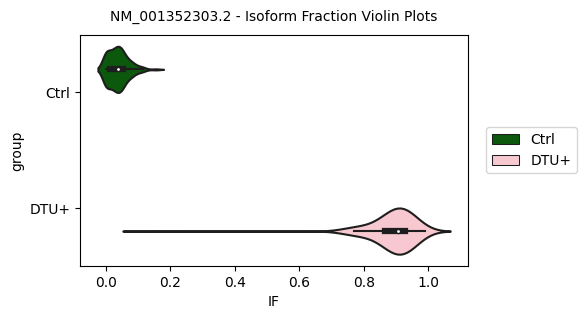

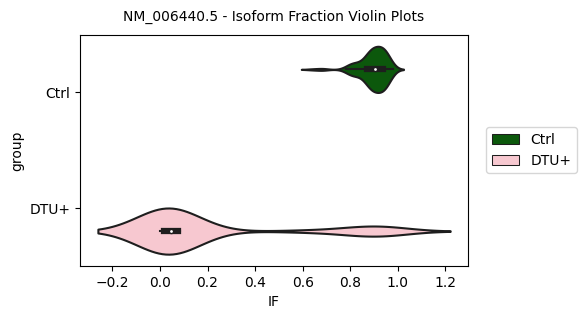

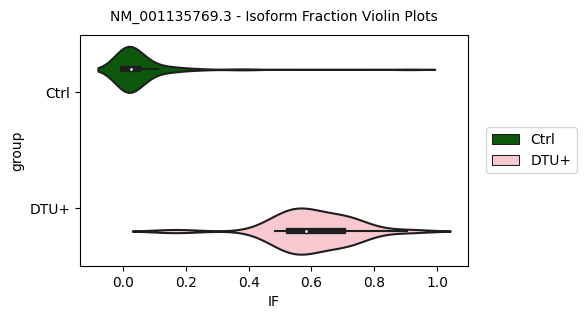

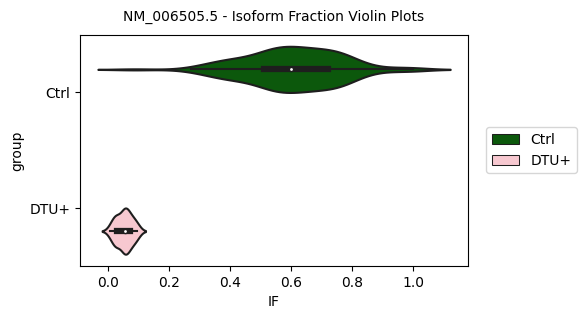

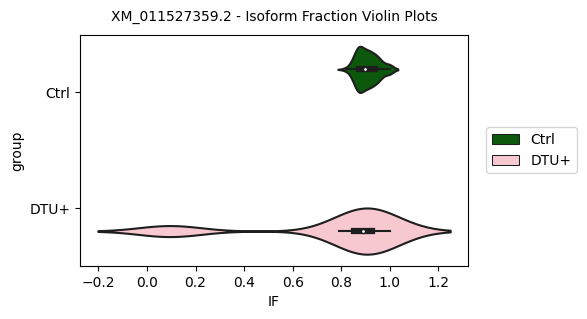

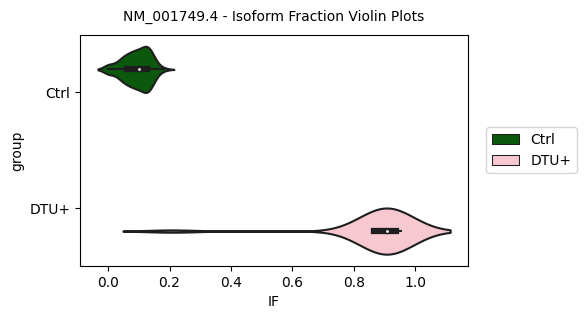

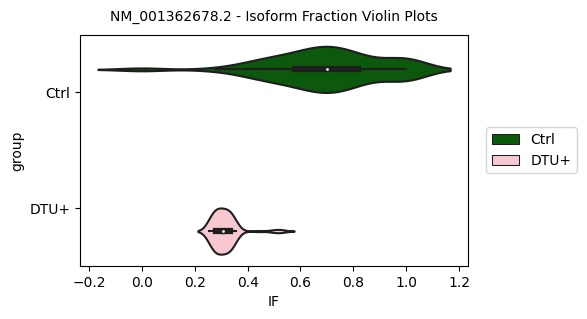

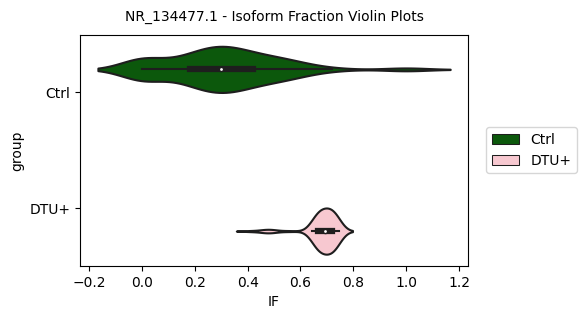

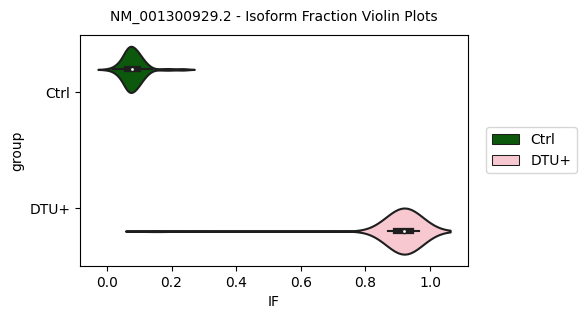

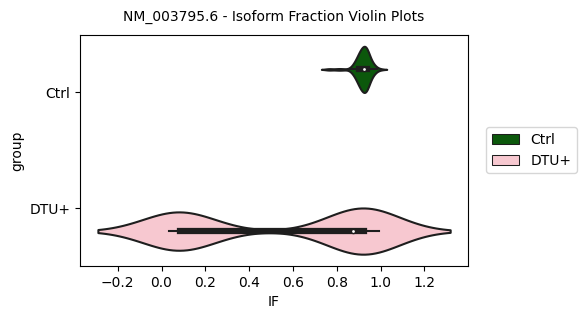

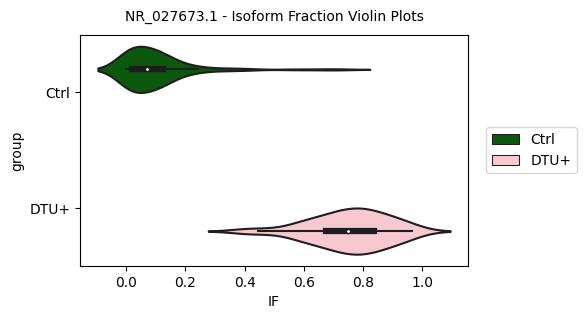

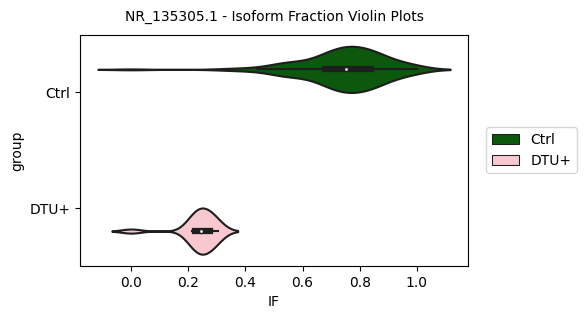

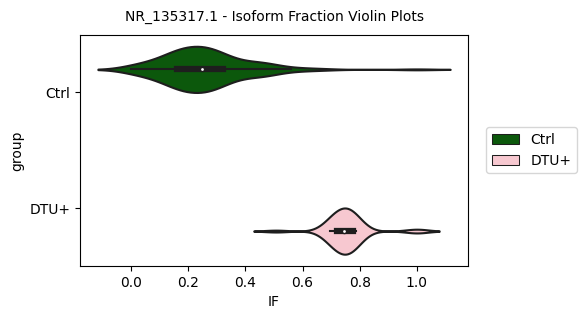

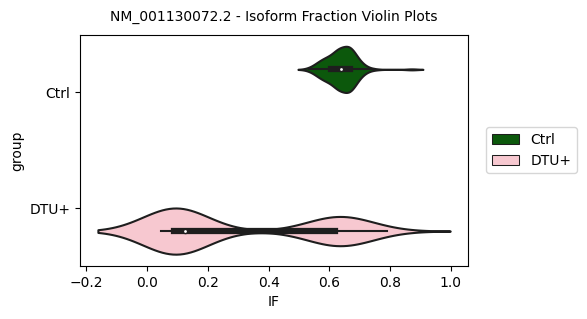

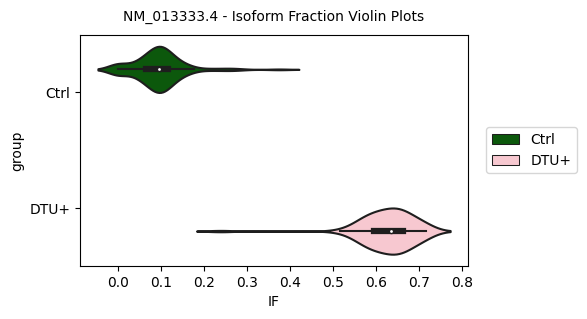

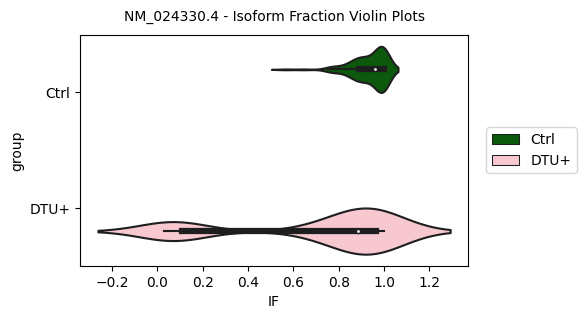

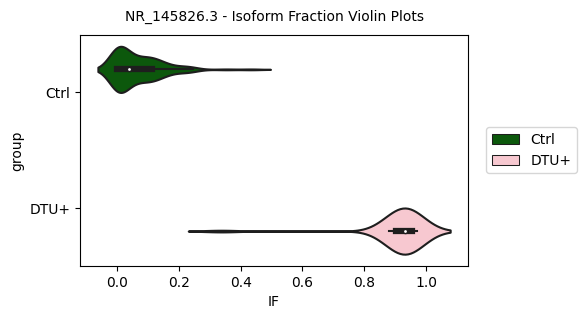

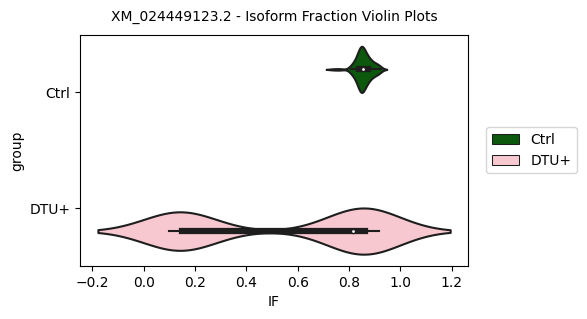

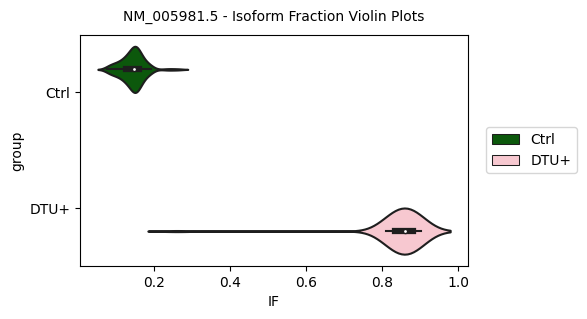

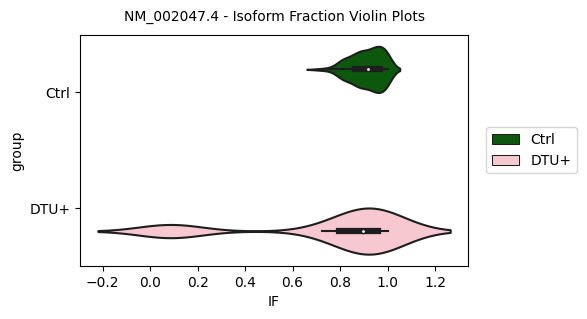

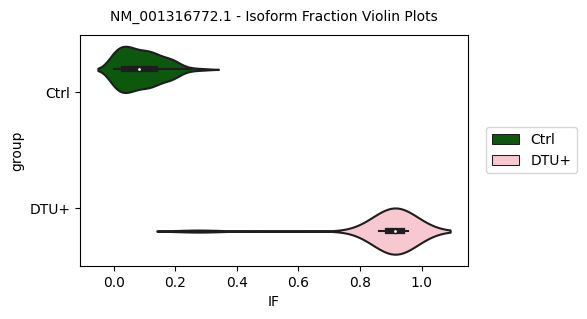

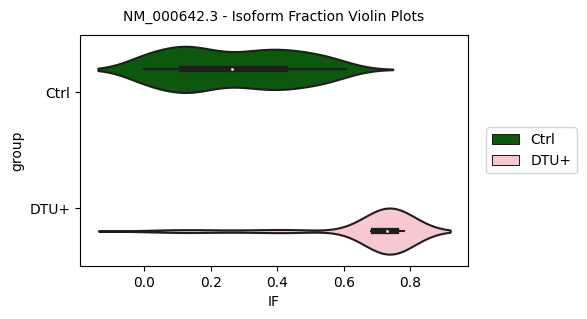

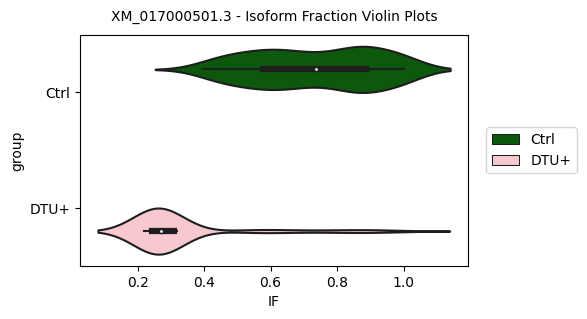

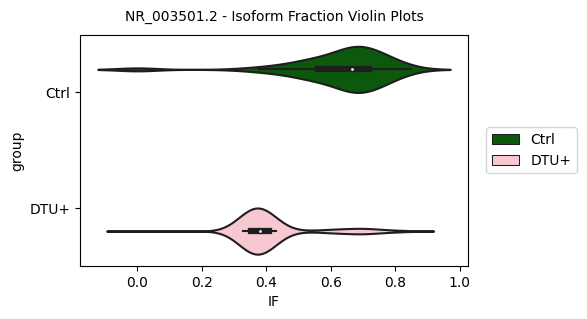

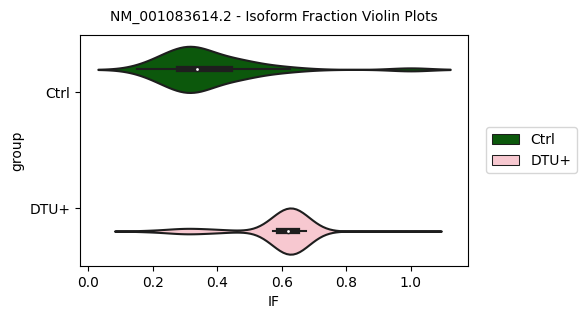

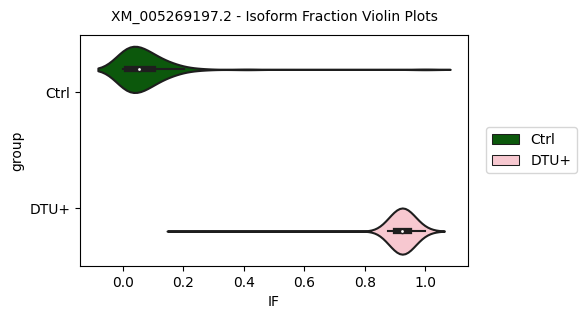

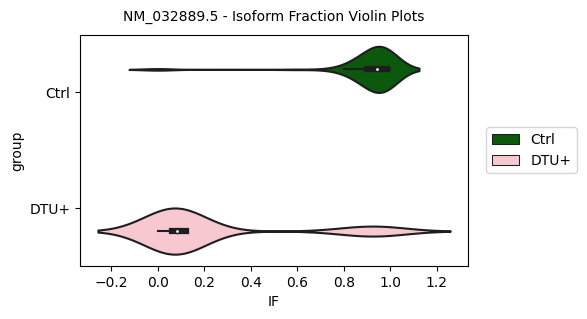

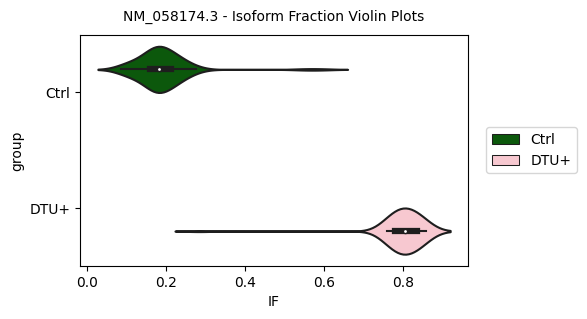

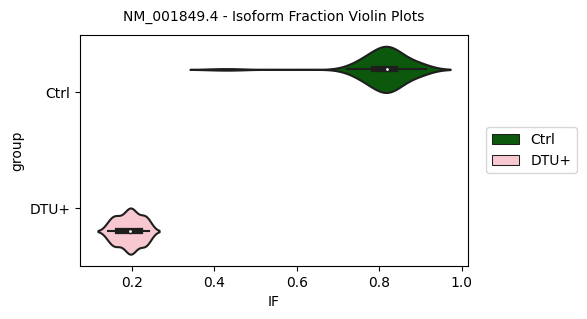

In [ ]:
#@markdown You can also create violin plots of the isoform fractions (IFs) for the final DTU transcripts by running this cell. The output shows the difference in the IF distributions between the control samples and the case samples in which a DTU event was detected (DTU+ samples) per transcript. You can customize the appearance according to your preferences using the generation code below.
import seaborn as sns
plt.rcParams['figure.figsize'] = [5, 3]
pheno_df = pd.read_csv(pheno, sep='\t')
ctrl_ids = pheno_df[pheno_df.condition == 0].id.to_list()
ifs = pd.read_csv(dominance_selected_ifs, sep = '\t', index_col = 0)
clm_dtu = pd.read_csv(controlled_spit_cluster_matrix, sep = '\t', index_col = 0)
sig_tx_ids = clm_dtu.index.to_list()
for i in sig_tx_ids:
    spit_v = clm_dtu.loc[i]
    dtu_plus = spit_v.index[(spit_v == 1)]
    df_index = ctrl_ids + dtu_plus.to_list()
    df_class = ["Ctrl" for i in range(len(ctrl_ids))] + ["DTU+" for i in range(len(dtu_plus))]
    df_if = ifs.loc[i][ctrl_ids].to_list() + ifs.loc[i][dtu_plus].to_list()
    tx_df = pd.DataFrame({'sample': df_index, 'group': df_class, 'IF':df_if})
    custom_palette = ["darkgreen", "pink"]  # Specify your desired colors here
    sns.set_palette(custom_palette)
    sns.violinplot(data=tx_df, x="IF", y="group", hue="group", fontdict = { 'fontsize': 30})
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.title(i + " - Isoform Fraction Violin Plots", size = 10, pad = 10)
    plt.show()

##Clustering the case group based on detected DTU events

Using SPIT’s output matrix, we are able to cluster the case samples into their separate genotype groups based on their shared events by applying hierarchical clustering. The chosen distance metric calculates the proportion of unique events between any two samples relative to the total number of DTU events.

The following plot is provided so that you can customize the appearance and clustering options according to your preferences using the generation code.

In [ ]:
#@markdown Install Python-R bridge:
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

In [ ]:
#@markdown If you have employed the filter-CPM thresholding (--f_cpm in DTU detection), you will have NA values in your SPIT cluster matrix for any samples that were not included in the DTU detection for a transcript. By running this cell, you may fill these NA values with 0s (non-DTU) for the clustering step:
unfilled_cluster_m = pd.read_csv(controlled_spit_cluster_matrix, sep = '\t', index_col = 0)
unfilled_cluster_m.fillna(0).to_csv('./controlled_spit_cluster_matrix_filled.txt', sep = '\t')

In [ ]:
#@markdown Install R packages
%%R
install.packages("gplots", lib = "/usr/local/lib/R/site-library", quiet = TRUE)
library_names <- c("tidyverse", "ggplot2", "tidyr", "grid", "RColorBrewer", "gplots")
for (library_name in library_names) {
  library(library_name, character.only = TRUE)
}

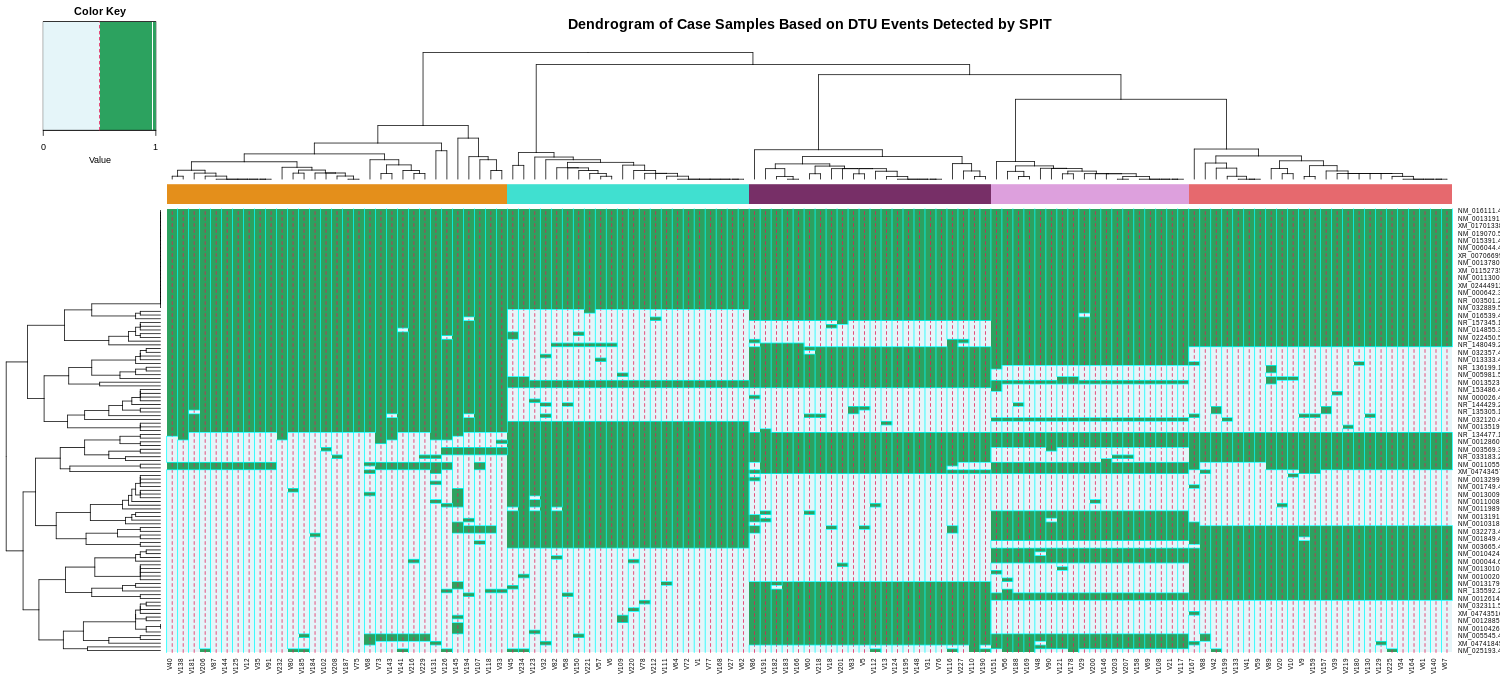

In [ ]:
#@title Plot dendrogram of case samples
#@markdown Note that the dendrogram ends are colored based on the 5 simulated genotypes that we introduced into this dataset. The heterogenous structure is successfully recovered based on the shared set of DTU events.
%%R -w 1500 -h 700
spit_cluster_m <- read.table("./controlled_spit_cluster_matrix_filled.txt", sep = "\t", header = TRUE, row.names = 1)
spit_cluster_m <- as.matrix(spit_cluster_m)
distance <- dist(t(spit_cluster_m), method = "binary") #other distance methods are "euclidean", maximum", "manhattan", "canberra", "binary" or "minkowski"
clusters <- hclust(distance, method = "complete") #other agglomeration methods are "ward.D", "ward.D2", "single", "complete", "average", "mcquitty", "median", or "centroid"
dendrogram <- as.dendrogram(clusters)

metadata = read.table("./SPIT/example_analysis/metadata.txt", header=TRUE, sep = '\t')
id_order <- colnames(spit_cluster_m)
metadata_reordered <- metadata[match(id_order, metadata$label), ]
genotype <- metadata_reordered$genotype
color_palette <- c("#E6696E", "turquoise", "#E48F1B", "#772F67", "plum")
color_vector <- color_palette[as.numeric(factor(genotype))]
gene_cor_dist <- as.dist(1 - cor(spit_cluster_m))

heatmap.2(spit_cluster_m, cexRow = 0.8, cexCol = 0.8, Colv = dendrogram,
          col= colorRampPalette(brewer.pal(3, "BuGn"))(2),
          lwid=c(1, 8), linecol = '#E41653',
          offsetRow = 0.05, offsetCol=0.05,
          ddistfun = function(x) gene_cor_dist,
          ColSideColors = color_vector,
          density.info = 'none',
          key.xtickfun=function() {
            breaks <- parent.frame()$breaks
            return(list(
              at=parent.frame()$scale01(c(breaks[1],
                                          breaks[length(breaks)])),
              labels=c(as.character(breaks[1]),
                       as.character(breaks[length(breaks)]))
            ))
          },
          main = "Dendrogram of Case Samples Based on DTU Events Detected by SPIT")

<img src="https://raw.githubusercontent.com/berilerdogdu/SPIT/main/resting_llama.png" height="200" align="center" style="height:240px">

If you use SPIT for academic work, please cite us:

In [ ]:
#@markdown P.S. If you need to remove the SPIT directory and rerun the pipeline, run this cell.
import shutil
shutil.rmtree('./SPIT')

#### **References**
**1-** Soneson C, Love MI and Robinson MD. Differential analyses for RNA-seq: transcript-level estimates improve gene-level inferences [version 1; peer review: 2 approved]. F1000Research 2015, 4:1521 (https://doi.org/10.12688/f1000research.7563.1)

**2-** Nowicka M, Robinson MD. DRIMSeq: a Dirichlet-multinomial framework for multivariate count outcomes in genomics. F1000Res. 2016 Jun 13;5:1356. doi: 10.12688/f1000research.8900.2. PMID: 28105305; PMCID: PMC5200948.

**3-** Human genomics. The Genotype-Tissue Expression (GTEx) pilot analysis: multitissue gene regulation in humans. Science 348, 648-60 (2015).